# Creating the Historical Visualization

In [7]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import Image, display

In [2]:
df = pd.read_pickle("data/historical_outbreaks.pkl")

print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
# A helper function to insert linebreaks into the hover data

def clean_description(d, max_char=30):
    
    # Capitalize first letter
    if d[0].islower():
        upper_char = d[0].upper()
        d = upper_char + d[1:]
    
    words = d.split()
    lines = ''
    current_line = ''
    
    for word in words:
        if len(current_line) + len(word) < max_char:
            current_line += word + ' '
        else:
            current_line += word + '<br>'
            lines += current_line
            current_line = ''
    
    if current_line:
        lines += current_line
            
    return lines
        
# Apply the function

df['Text'] = df['Description'].apply(clean_description) 

In [15]:
def generate_historical_viz(df, min_year=1709, max_year=2010, past_years=50):
    
    # Take care of errors
    assert min_year < max_year, "Start year must be before end year."
    assert past_years <= 50, "Maximum past years is 50."
    assert min_year >= -1800, "Minimum start year is -1800."
    assert max_year <= 2010, "Maximum end year is 2010."
    
        
    
    # Filter the DataFrame
    df = df.loc[(df['Year']>=min_year) & (df['Year']<=max_year) & (df['Years_Since_Outbreak']<=past_years)]
    
    
    # Extract unique years
    years = df['Year'].unique()

    # Create a template for hover data
    hover_temp = 'Country: %{customdata[0]}<br>\
    Outbreak Year: %{customdata[1]}<br>\
    Years Since Outbreak: %{customdata[2]}<br><br>\
    Description:<br>%{customdata[3]}\
    <extra></extra>'


    # Create a list to store frames
    frames = []

    # Create frames for each year
    for year in years:
        filtered_df = df[df['Year'] == year]
        frame = go.Frame(data=[
            go.Choropleth(
                locations=filtered_df['Country'],
                locationmode='ISO-3',
                z=filtered_df['Years_Since_Outbreak'],
                colorscale = px.colors.sequential.Reds_r,
                colorbar_title='Years Since<br>Outbreak',
                customdata = filtered_df[['Country', 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
                hovertemplate=hover_temp,
                colorbar = dict(
                    bgcolor='white',
                    x=.03,
                    y=.1,
                    xanchor='left',
                    yanchor='bottom',
                    len=.45,
                    bordercolor='black',
                    borderwidth=1,    
                ),
                zmin=0,
                zmax=past_years,
            )
        ],
            name=f'Frame {year}'
        )
        frames.append(frame)

    # Create the initial choropleth map
    fig = go.Figure(data=[
        go.Choropleth(
            locations=df.loc[df['Year']==df['Year'].min()]['Country'],
            locationmode='ISO-3',
            z=df['Years_Since_Outbreak'],
            colorscale=px.colors.sequential.Reds_r,
            colorbar_title='Years Since<br>Outbreak',
            customdata = df[['Country', 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
            hovertemplate=hover_temp,
            colorbar = dict(
                    bgcolor='white',
                    x=.03,
                    y=.1,
                    xanchor='left',
                    yanchor='bottom',
                    len=.45,
                    bordercolor='black',
                    borderwidth=1,
                    outlinewidth=.5,
                    outlinecolor='black',
                    nticks=10,
                    ticks='outside',

                ),
            zmin=0, 
            zmax=past_years,  
        )
    ])


    # Add frames to the figure
    fig.frames = frames

    # Select map version
    fig.update_geos(
        showcountries=True,
        landcolor='lightgreen',
        showocean=True,
        oceancolor='lightskyblue',
        showlakes=True,
        lakecolor='navy'
    )

    # Update layout properties
    fig.update_layout(
        title_text=f"Major Zoonotic Outbreaks by Country: {df['Year'].min()} - {df['Year'].max()}",
        title_font_size=30,
        title_x=.5,
        title_y=.9,
        height=600,
        width=1000,

        # Add buttons to interact with
        updatemenus=[{
            'type': 'buttons',
            'x': .08,
            'y': -.025,
            'showactive': True,
            'buttons': [{
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'fromcurrent': True,
                    'frame': {'duration': 500, 'redraw': True},
                    'transition': {'duration': 300, 'easing': 'quadratic-in-out'}
                }]
            }, {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }]
        }],

        # Add the year slider
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Current Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 0, 't': 0},
            'len': 0.9,
            'x': 0.1,
            'y': 0.00,
            'steps': [{
                'args': [[f'Frame {year}'], {
                    'frame': {'duration': 300, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 300}
                }],
                'label': f' {year}',
                'method': 'animate'
            } for year in years]
        }],
    )

    return fig

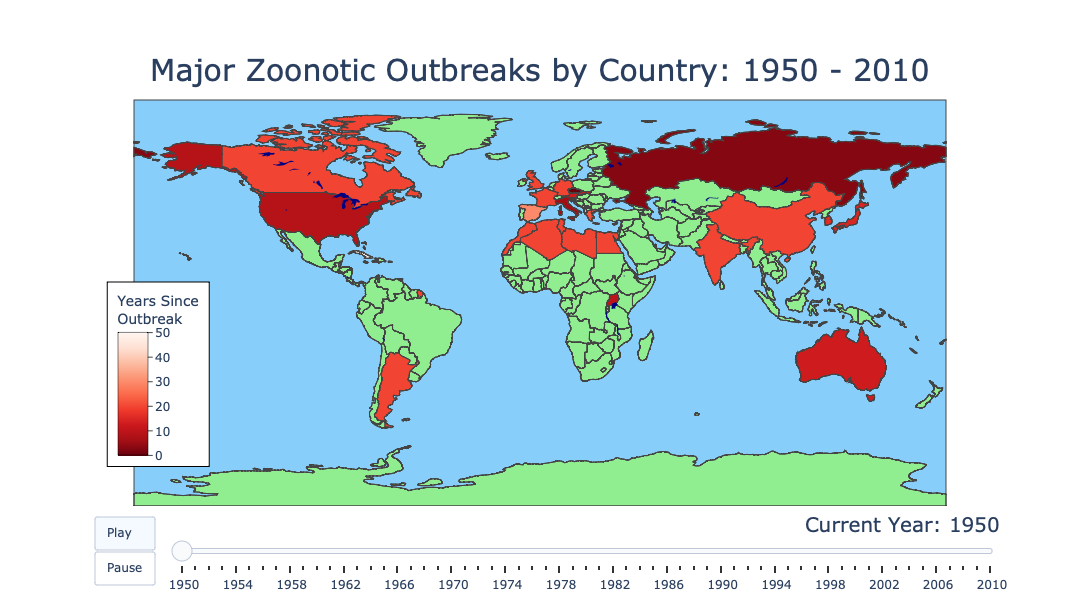

In [16]:
generate_historical_viz(df, 1950, 2010, 50)

If you are having trouble generating the interactive image above, here is a static image. You won't be able to see the mouseover data, but feel free to play with the function parameters to view different versions of the image.

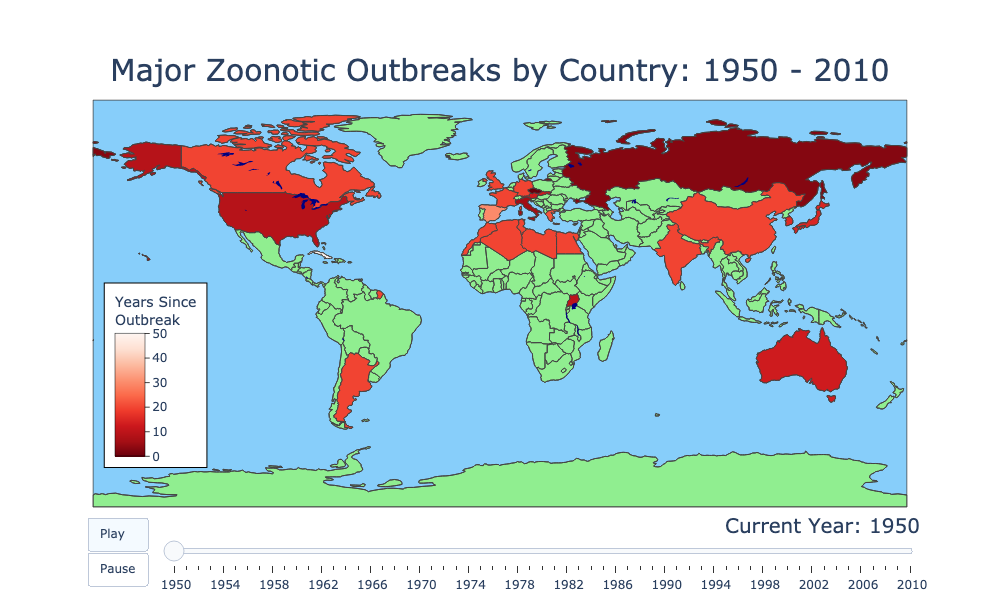

In [17]:
fig = generate_historical_viz(df, 1950, 2010, 50)
image_bytes = pio.to_image(fig, format="png")
Image(data=image_bytes)